# Part 2: Dynamical spin structure factor

## Part a

In [1]:
import a_mps_Gio, b_model_Gio, c_tebd_Gio
import numpy as np
from scipy.linalg import svd
import importlib 
import matplotlib.pyplot as plt
#from tqdm import tqdm


### Quick theoretical analysis Ising Model

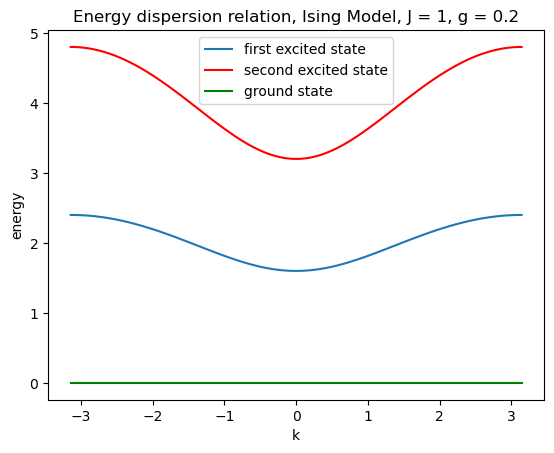

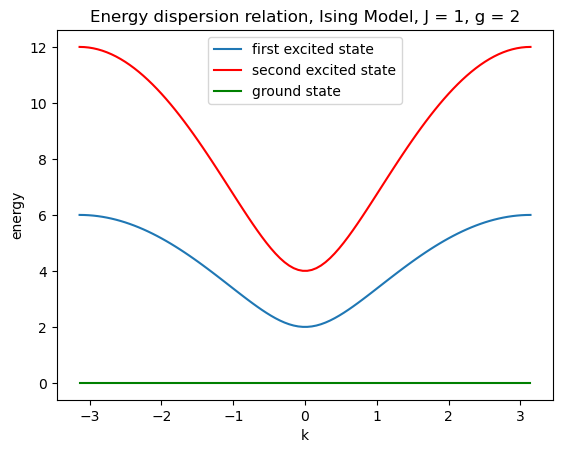

In [2]:
function = lambda k, n, g: +2*n*np.sqrt((np.cos(k)-g)**2 + np.sin(k)**2)
k = np.linspace(-np.pi, np.pi, 100)
for g in [0.2, 2]:
    plt.plot(k, function(k, 1, g), label = 'first excited state')
    plt.plot(k, function(k, 2, g), 'red', label = 'second excited state')
    plt.plot(k, np.zeros_like(k), 'green', label = 'ground state')
    plt.xlabel('k')
    plt.ylabel('energy')
    plt.title(f'Energy dispersion relation, Ising Model, J = 1, g = {g}')
    plt.legend()
    plt.show()

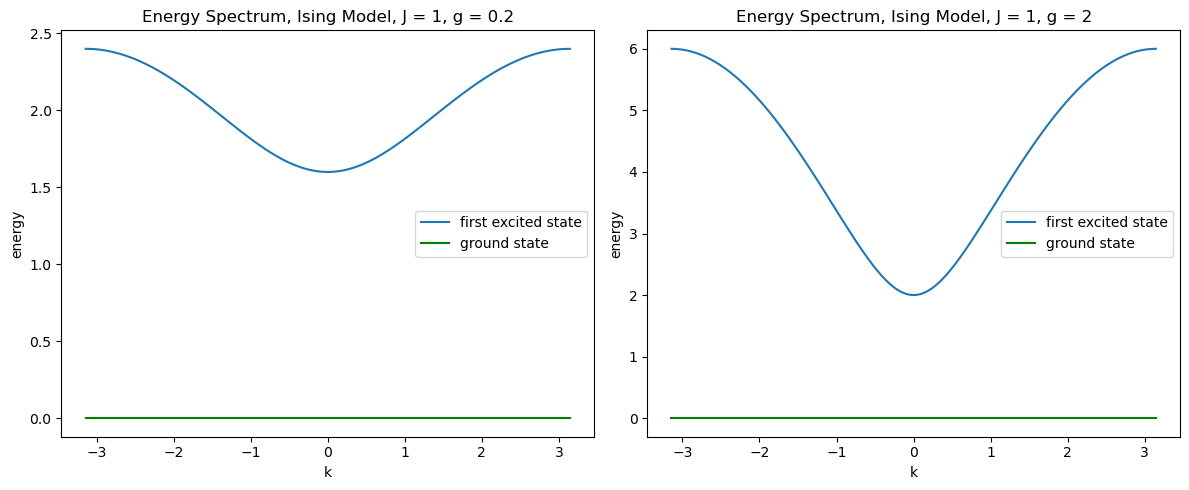

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, g in enumerate([0.2, 2]):
    ax[i].plot(k, function(k, 1, g), label='first excited state')
    #ax[i].plot(k, function(k, 2, g), 'red', label='second excited state')
    ax[i].plot(k, np.zeros_like(k), 'green', label='ground state')
    ax[i].set_xlabel('k')
    ax[i].set_ylabel('energy')
    ax[i].set_title(f'Energy Spectrum, Ising Model, J = 1, g = {g}')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [4]:
importlib.reload(a_mps_Gio)
importlib.reload(b_model_Gio)
importlib.reload(c_tebd_Gio)

<module 'c_tebd_Gio' from '/home/t30/pol/go56vod/Desktop/Fopra32/c_tebd_Gio.py'>

In [5]:
sigmay = np.array([[0,-1j],[1j,0]])
sigmax = np.array([[0,1],[1,0]])


## Right code!

In [6]:
def correlation_Ctj(L, J, g, X, Y, T, dt, h = 0): #model - Hamiltonian, psi - class of wave function, T - last time step 
    E0, psi, model = c_tebd_Gio.example_TEBD_gs_finite(L,J,g, h)
    psi1 = psi.copy() #take a copy of psi which is ground state
    S = []
    i = L//2 # i= L//2 index of Y
    tensor1 = np.tensordot(psi.Bs[i], Y, [1,1]) # vL [i] vR, i [i*] -> vL vR i
    psi.Bs[i] = tensor1.transpose([0,2,1])
    U_bond = c_tebd_Gio.calc_U_bonds_real(model, dt)
    result = []
    TT = int(T//dt)
    for r in range(TT):

        exp_factor = np.exp(1j*E0*r*dt)
        if r != 0:
            c_tebd_Gio.run_TEBD(psi, U_bond, N_steps=1, chi_max=100, eps=1.e-10) #found new psi by applying e^-iHdt
        S.append(psi.entanglement_entropy())
        tensor1 = [np.array([[1]])]
        tensor1.append(np.tensordot(psi.Bs[L-1], psi1.Bs[L-1].conj(), [[1,2],[1,2]])) # vL [i] [vR] , vL* [i*] [vR*] -> vL vL*
        k=1
        #indeces of Bs go from 0 to L-1
        #for j in range(10) goes from 0 to 9 
        #for j in range (9,0,-1) goes from 9 to 1
        for j in range(L-2,0,-1):
            tensor2 = np.tensordot(psi.Bs[j],tensor1[k], [2,0]) # vL i [vR] ,[vL] vL* -> vL i vL*
            tensor1.append(np.tensordot(tensor2, psi1.Bs[j].conj(), [[1,2],[1,2]])) # vL [i] [vL*], vL* [i*] [vR*] ->  vL vL*
            #tensor2 = np.tensordot(psi1.Bs[j], psi.Bs[j].conj(), [1,1])  vL [i] vR , vL* [i*] vR* -> vL vR vL* vR*
            #tensor1.append(np.tensordot(tensor2,tensor1[k],[[1,3],[0,1]])) # vL [vR] vL* [vR*], [vL] [vL*] -> vL vL*
            k+=1
        # print(len(tensor1)) 
        #k = L-1
        result.append([])
        tensorA = np.tensordot(psi.Bs[0], psi1.Bs[0].conj(),[[0,1],[0,1]]) # [vL] [i] vR , [vL*] [i*] vR* -> vR vR*
        tensorB = np.tensordot(psi.Bs[0], X, [1,1]) # vL [i] vR , i [i*] -> vL vR i
        tensorC = np.tensordot(tensorB,psi1.Bs[0].conj(), [[0,2],[0,1]]) # [vL] vR [i], [vL*] [i*] vR* -> vR vR*
        result[r].append(np.tensordot(tensorC,tensor1[L-1], [[0,1],[0,1]])) # [vR] [vR*], [vL] [vL*]

        for j in range(1,L):
            tensorB = np.tensordot(psi.Bs[j], X, [1,1]) # vL [i] vR , i [i*] -> vL vR i
            tensorbeforeC = np.tensordot(tensorA, tensorB, [0,0]) # [vR] vR*, [vL] vR i -> vR* vR i
            tensorC = np.tensordot(tensorbeforeC,psi1.Bs[j].conj(), [[0,2],[0,1]]) # [vR*] vR [i], [vL*] [i*] vR* -> vR vR*
            #print(tensorC.shape)
            #print(tensor1[L-j-2].shape) #- mettili se c'è sum mismatch prima di un certo tensorproduct
            result[r].append(np.tensordot(tensorC,tensor1[L-j-1], [[0,1],[0,1]])) # [vR] [vR*], [vL] [vL*]
            #tensorintermediate = np.tensordot(psi1.Bs[j], psi.Bs[j].conj(),[1,1]) # vL [i] vR , vL* [i*] vR* -> vL vR vL* vR*
            #tensorloop = np.tensordot(tensorA, tensorintermediate, [[0,1],[0,2]]) # [vR] [vR*], [vL] vR [vL*] vR* -> vR vR*
            tensorintermediate = np.tensordot(tensorA, psi.Bs[j], [0,0]) # [vR] vR*, [vL] i vR -> vR* i vR
            tensorloop = np.tensordot(tensorintermediate, psi1.Bs[j].conj(), [[0,1],[0,1]]) # [vR*] [i] vR, [vL*] [i*] vR* -> vR vR*
            tensorA = tensorloop

        result[r] = np.array(result[r])* exp_factor

    return S, result

In [ ]:
S_ferro, Corr_ferro = correlation_Ctj(L = 50, J = 1.,g = 0.15, X = sigmay, Y = sigmay, T = 40, dt = 0.01)
#S_ferro, Corr_ferro = correlation_Ctj(L = 30, J = 1.,g = 0.2, X = sigmay, Y = sigmay, T = 25, dt = 0.01)

finite TEBD, (imaginary time evolution)
L=50, J=1.0, g=0.15, h = 0
dt = 0.10000: E = -49.2928614404133
dt = 0.01000: E = -49.2929224406913
dt = 0.00100: E = -49.2929289314531
dt = 0.00010: E = -49.2929295839861
dt = 0.00001: E = -49.2929296492454
final bond dimensions:  [2, 4, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 4, 2]


In [ ]:
S_para, Corr_para = correlation_Ctj(L = 80, J = 1., g = 2., X = sigmay, Y = sigmay, T = 15, dt = 0.01)
# S_para, Corr_para = correlation_Ctj(L = 50, J = 1., g = 2., X = sigmay, Y = sigmay, T = 10, dt = 0.01)

finite TEBD, (imaginary time evolution)
L=80, J=1.0, g=2.00, h = 0
dt = 0.10000: E = -169.1949130860354
dt = 0.01000: E = -169.9527034647366
dt = 0.00100: E = -170.0272657169263
dt = 0.00010: E = -170.0346907485010
dt = 0.00001: E = -170.0354338713381
final bond dimensions:  [2, 4, 8, 12, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 12, 8, 4, 2]


In [105]:
import pickle

In [106]:
# Save
with open("S_ferro.pkl", "wb") as f:
    pickle.dump(S_ferro, f)

with open("Corr_ferro.pkl", "wb") as f:
    pickle.dump(Corr_ferro, f)

In [107]:
# Save
with open("S_para.pkl", "wb") as f:
    pickle.dump(S_para, f)

with open("Corr_para.pkl", "wb") as f:
    pickle.dump(Corr_para, f)

If i need to load the corr and entropy because I have closed the file:

In [ ]:
#Load
file_names = ["S_ferro.pkl", "S_para.pkl", "Corr_ferro.pkl", "Corr_para.pkl"]
loaded_data = []

for file in file_names:
    with open(file, "rb") as f:
        loaded_data.append(pickle.load(f))

Plot of Entanglement Entropy

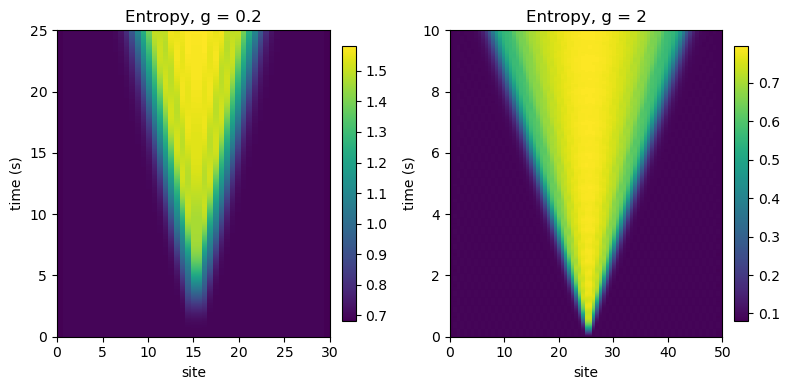

In [108]:
rows = 1
cols = 2
fig, ax = plt.subplots(rows, cols, figsize = (8,4))

im = ax[0].imshow(S_ferro, aspect='auto', interpolation='none', origin = 'lower',  extent = [0, 30, 0, 25])
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)  # Add colorbar
ax[0].set_title('Entropy, g = 0.2')
ax[0].set(xlabel = 'site', ylabel = 'time (s)')

im = ax[1].imshow(S_para, aspect='auto', interpolation='none', origin = 'lower',  extent = [0, 50, 0, 10])
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)  # Add colorbar
ax[1].set_title('Entropy, g = 2')
ax[1].set(xlabel = 'site', ylabel = 'time (s)')

plt.tight_layout()

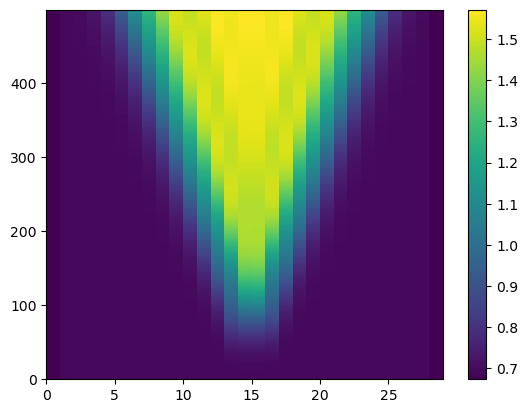

In [28]:
#plt.imshow
#plt.pcolormesh
#plt.plot()
#T = np.arange(1,201,1)
#print(T)
#Hey = [T,S]
plt.pcolormesh(S_ferro, cmap = 'viridis')
plt.colorbar()

Plot of Correlation Function

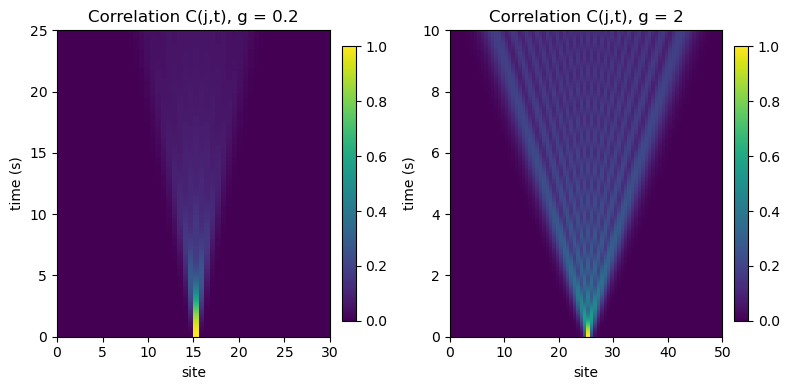

In [110]:
rows = 1
cols = 2
fig, ax = plt.subplots(rows, cols, figsize = (8,4))

im = ax[0].imshow(np.abs(Corr_ferro), aspect='auto', interpolation='none', origin = 'lower',  extent = [0, 30, 0, 25])
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)  # Add colorbar
ax[0].set_title('Correlation C(j,t), g = 0.2')
ax[0].set(xlabel = 'site', ylabel = 'time (s)')

im = ax[1].imshow(np.abs(Corr_para), aspect='auto', interpolation='none', origin = 'lower',  extent = [0, 50, 0, 10])
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)  # Add colorbar
ax[1].set_title('Correlation C(j,t), g = 2')
ax[1].set(xlabel = 'site', ylabel = 'time (s)')

plt.tight_layout()

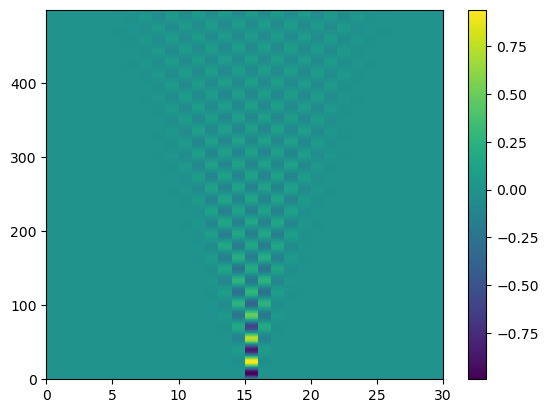

In [29]:
plt.pcolormesh(np.imag(Corr_ferro), cmap = 'viridis')
plt.colorbar()

## Part b 

- Write another function that performs a Fourier transformation in space and time to obtain the dynamic structure factor $S(k, \omega)$:

$$
S(k, \omega) = \sum^{L−1}_{j=0} \sum^N_{t_n = 0}e^{i\omega \delta t \cdot t_n − i k \cdot j} C(\Delta t \cdot t_n, j) · G(tn)
$$


- Remember to multiply the signal with a Gaussian window function G(tn) in order to avoid Gibbs oscillations from the Fourier transform of the finite time data (cf. equation (7)).

In [9]:
import FourierTransform as FT
importlib.reload(FT)

<module 'FourierTransform' from '/home/t30/pol/go56vod/Desktop/Fopra32/FourierTransform.py'>

Now we have found C(t,j)= C_t,j which is a matrix (list) with each row corresponding to a specific time step where correlation function is evaluated for each site j (for sigmay_j) 

In [111]:
Corr_ferro = np.array(Corr_ferro)
Corr_para = np.array(Corr_para)

In [113]:
Swk_ferro, momenta_ferro, freqs_ferro = FT.get_Swk(Corr_ferro, L = 50, dt = 0.01)
Swk_para, momenta_para, freqs_para = FT.get_Swk(Corr_para, L = 80, dt = 0.01)


Compute Fourier transform
finished
Compute Fourier transform
finished


# Part c: 
Obtain S(k,w) and plot it

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1999
(51,)
51


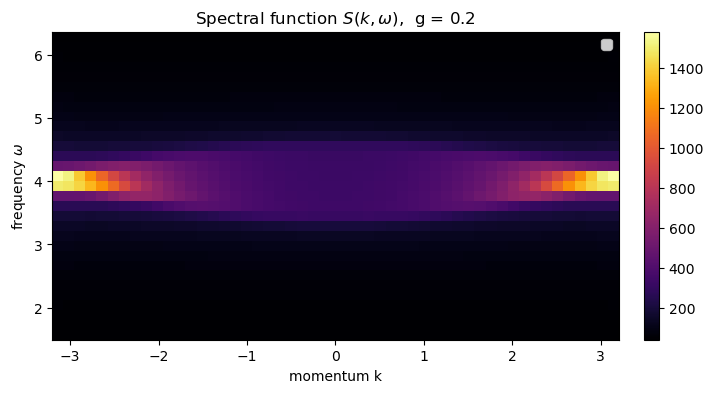

In [115]:
FT.plot_Swk(Swk_ferro, momenta_ferro, freqs_ferro, title = r'Spectral function $S(k, \omega)$,  g = 0.2', offset=10, interval=30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


749
(81,)
81


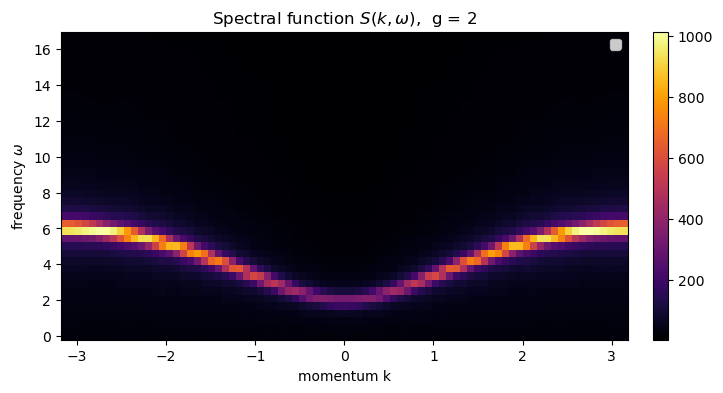

In [119]:
FT.plot_Swk(Swk_para, momenta_para, freqs_para, title = r'Spectral function $S(k, \omega)$,  g = 2', offset=0, interval=40)

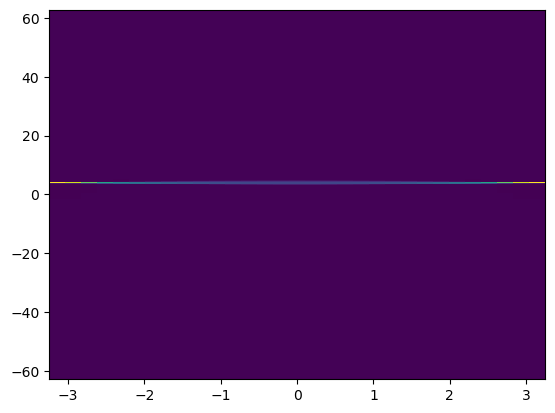

In [33]:
plt.figure()
plt.pcolormesh(momenta, freqs, np.real(Swk))

### $S(k,\omega)$ at g= 0.2 and h = 0.1

In [12]:
S_new, Corr_new = correlation_Ctj(L = 50, J = 1.,g = 0.2, X = sigmay, Y = sigmay, T = 40, dt = 0.0001, h = 0.1)

finite TEBD, (imaginary time evolution)
L=50, J=1.0, g=0.20, h = 0.1
dt = 0.10000: E = -54.4942579258112
dt = 0.01000: E = -54.4944020982102
dt = 0.00100: E = -54.4944174370683
dt = 0.00010: E = -54.4944189792072
dt = 0.00001: E = -54.4944191334396
final bond dimensions:  [2, 4, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 2]


Compute Fourier transform


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


finished
199999
(51,)
51


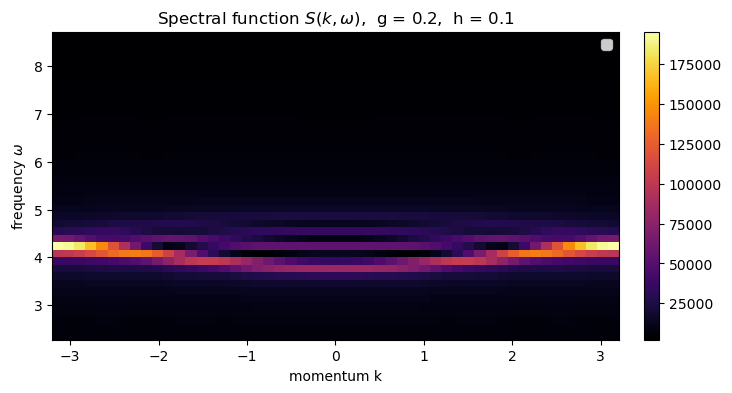

In [13]:
Corr_new = np.array(Corr_new)
Swk_new, momenta_new, freqs_new = FT.get_Swk(Corr_new, L = 50, dt = 0.0001)
FT.plot_Swk(Swk_new, momenta_new, freqs_new, title = r'Spectral function $S(k, \omega)$,  g = 0.2,  h = 0.1', offset=15, interval=40)

PUNTO PRINCIPALE del colloquium: capire la fisica di quello che si sta vedendo!